# PID control

Dans les travaux précédents on a pu identifier la fonction de transfert liant l'echauffement $Q1$ à la température $T1$ comme :
- un 1er ordre avec retard pur
$$ G_1(s) = \frac{\Delta T_1(s)}{Q_1(s)}= \frac{0.46e^{-21s}}{151s + 1} $$
- un second ordre
$$ G_1(s) = \frac{\Delta T_1(s)}{Q_1(s)}= \frac{0.46}{(21s + 1)(151s + 1)} $$

$\Delta T_1$ exprimant ici l'écart relatif entre la température du capteur et la température ambiante (autour de 20°C).

On peut trouver [ici](http://www8.umoncton.ca/umcm-cormier_gabriel/Asservissements/GELE5313_Notes7.pdf) un cours sur les asservissements introduisant les différentes formes de correcteurs. L'approche Ziegler-Nichols de réglage de ces correcteurs est notemment rappelé :
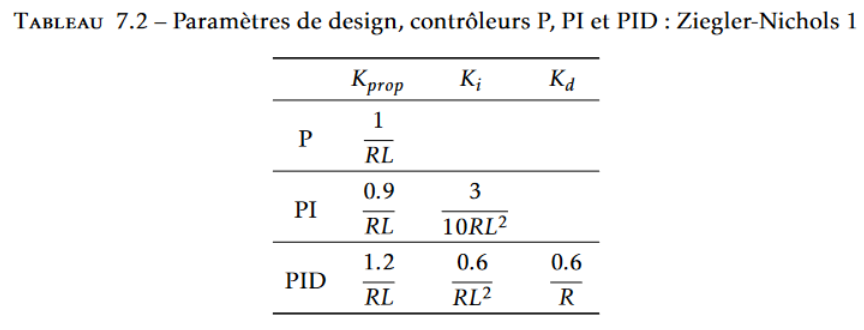

pour un système de fonction de transfert de la forme $ G(s) = \frac{Ke^{-Ls}}{\tau s + 1} $ avec $R=K/\tau$.



> Réaliser le controle en température avec correcteur proportionnel de type PI. Analyser les performances par simulation de manières temporelles et fréquentielles (Bode en boucle ouverte et boucle fermée). Comparer ces résultats à des essais réels. 




# PI Controller define with Zielgler-Nichols method

On reprend l'approche Ziegler-Nichols sur un controleur PI defini avec la fonction de transfert suivante:
$G_c(s)=k_p(1+\frac{1}{\tau_i s}+\tau_d s)=k_p+\frac{k_i}{s}+k_s s$

Definit les gain suivant pour le controleur:  
$k_p = \frac{1.2}{RL}$  
$k_i = \frac{0.6}{R L^2}$  
$k_d = \frac{0.6}{R}$


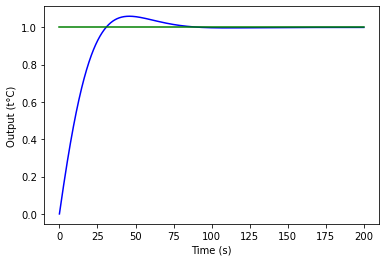

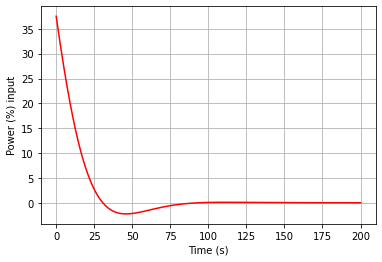

In [169]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import control.matlab as control

# Ziegler Nichols input parameter
tau = 151 # [s] time constant of the 1st order
L= 21 # [s] delay
K = 0.46 # [°/%] static gain

R=K/tau

# controller coefficient with Ziegler Nichols approach

k=2
Kp = 1.2/R/L*k
Ki = 0.6/R/L**2/k
Kd = 0.6/R*k


# system transfer function, based on second order model
G1 = 0.46*control.tf([1],[21,1])*control.tf([1],[151,1])

# controller and global model transfer functions
Gc = control.tf([Kd,Kp, Ki],[1, 0])
T = Gc*G1
H = T/(1+T)

# Step response of the closed loop
t = np.linspace(0,200,1000)
y,t = control.step(H,t)
Q,t = control.step(Kp/(1+T),t)
plt.plot(t,y, 'b', t,np.ones(1000),'g-')
plt.xlabel('Time (s)')
plt.ylabel('Output (t°C)')
plt.show()

plt.plot(t,Q, 'r')
plt.xlabel('Time (s)')
plt.ylabel('Power (%) input')
plt.grid()
plt.show()

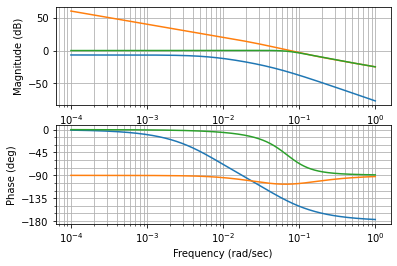

In [125]:
# Bode diagram of open loops
mag,phase,omega = control.bode(G1,T,H)

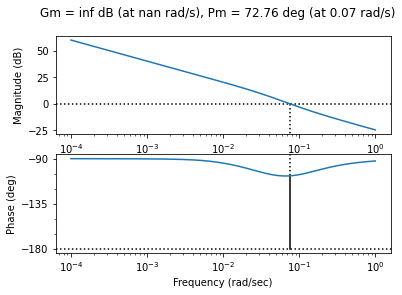

In [126]:
# Print phase and gain margins
mag,phase,omega = control.bode(T, margins = True)

# Implementation of a simple PID controller

La fonction de transfert d'un controleur Proportionnel - Integral PI est la suivante :
$G_c(s)=k_p+\frac{k_i}{s}+k_d s$

Given a process variable $PV$ and setpoint $SP$, proportional-integral-derivative control determines the value of a manipulated variable MV by the rule

\begin{align}
MV & = \bar{MV} + K_p\left(SP - PV\right) + K_i \int_0^t \left(SP-PV)\right)dt + K_d \frac{d\left(SP-PV\right)}{dt}
\end{align}

where $K_p$, $K_i$, and $K_d$ are the proportional, integral, and derivative coefficients, respectively. 

The following code defines a Python object that implements this algorithm.



In [179]:
class PID:
    def __init__(self):
        self.Kp = 1
        self.Ki = 100
        self.Kd = 0

        self.e = 0
        self.dedt = 0
        self.eint = 0
        self.mv = 0
        self.pt = 0
        
    def update(self, setpoint, pv, t):
        e = setpoint - pv
        dt= t-self.pt
        self.pt=t
        if dt != 0 :
            self.dedt = (e - self.e)/dt
        else :
            self.dedt = 0            
                
        self.eint += e*dt
        self.e = e

        self.mv = self.Kp * self.e + self.Ki * self.eint + self.Kd * self.dedt
        
        # anti-Windup
        self.MVsat = max(0, min(100, self.mv))
        # si saturation on arrete d'integrer l'action integrale
        if self.MVsat != self.mv :
            print(".", end='')
            self.eint -= e*dt
            
        return self.mv
    
        

The following cell provides an initial implementation of PID control for heater T1.  

In [189]:
from labtime import clock
from tclab import TCLab

#from tclab import TCLab

lab = TCLab()
lab.LED(100)


# from tclab import TCLab

print("Temperature 1: %0.2f °C"%(lab.T1))
print("Temperature 2: %0.2f °C"%(lab.T2))

import matplotlib.pyplot as plt
import numpy as np

time = []
Q1 = []
Kperror = []
T1 = []

Torder = 40

tfinal = 400
tstep = 1

pid = PID()
pid.Kp = Kp
pid.Ki = Ki
pid.Kd = Kd


for t in clock(tfinal, tstep):
    print('.', end='')
    Q = pid.update(Torder, lab.T1, t)
    lab.Q1(Q)
    time = time + [t]
    T1 = T1 + [lab.T1]
    Q1 = Q1 + [Q]
    
    
print("\nTurn Heater Q1 Off")
lab.Q1(0)
lab.close()

Opening connection
TCLab connected via Arduino on port COM5
Temperature 1: 20.25 °C
Temperature 2: 19.93 °C
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Turn Heater Q1 Off
Arduino disconnected successfully


True

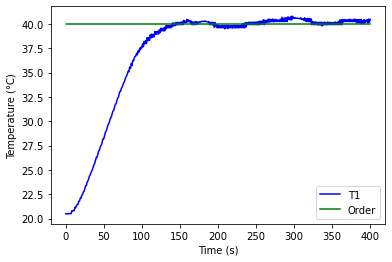

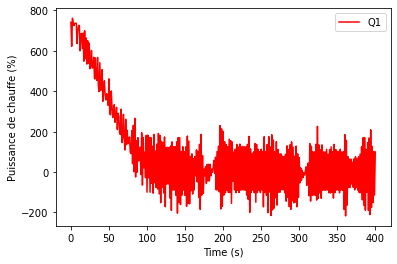

In [190]:
plt.plot(time, T1,'b-', label='T1')
plt.plot(time, np.ones(len(time))*Torder,'g-', label='Order')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

plt.plot(time, Q1,'r-', label='Q1')
plt.xlabel('Time (s)')
plt.ylabel('Puissance de chauffe (%)')
plt.legend()
plt.show()

In [188]:
lab.close()

Arduino disconnected successfully


True

.....................................................................

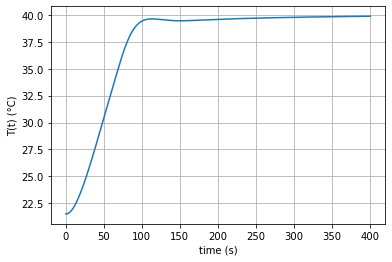

In [185]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

Torder=40

pid = PID()
pid.Kp = Kp
pid.Ki = Ki
pid.Kd = Kd



def rungekutta1(f, y0, t):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(n - 1):
        y[i+1] = y[i] + (t[i+1] - t[i]) * np.array(f(y[i], t[i]))
    return y


# function that returns dy/dt
def model(y,t):
    T, Tp = y
    # Controller
    Q = pid.update(Torder, T, t)
    Qsat = max(0,min(100, Q))
    
    # System
    Tpp = (0.46*Qsat-(T-21.5)-151*Tp)/(21*151)
    dydt = [Tp, Tpp]
    return dydt 

# initial condition
T0 = [21.5,0]

# time points
t = np.linspace(0,400,401)

# solve ODE
#y = odeint(model,T0,t)
y = rungekutta1(model,T0,t)

# plot results
plt.plot(t,y[:,0])
plt.xlabel('time (s)')
plt.ylabel('T(t) (°C)')
plt.grid()
plt.show()


In [3]:
!pandoc 03.03-Lab-PID-Control.ipynb -s -o essai.docx